# AdaBoost, GradientBoost, LightGBM, and XGBoost

In [13]:
import pandas as pd
import numpy as np
import pickle
import time

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix

from lightgbm import LGBMClassifier

from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as imbPipeline

from category_encoders import TargetEncoder

import warnings
warnings.filterwarnings('ignore')

In [14]:
X_train = pd.read_csv('Data/X_train.csv', index_col='building_id')
X_test = pd.read_csv('Data/X_test.csv', index_col='building_id')
y_train = pd.read_csv('Data/y_train.csv', index_col='building_id')
y_test = pd.read_csv('Data/y_test.csv', index_col='building_id')

In [15]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [16]:
#Create a dictionary and helper function to track model scores.
score_dict = {}
def print_scores():
    for key in score_dict.keys():
        print(f'{key},\t f1_micro_score: {round(score_dict[key][0],4)},\t Run time: {round(score_dict[key][1],0)}')

### Divide Columns and drop unimportant features

Let's start by dropping unimportant features and using target encdoing, which was our best approach with the Random Forest models.  Then we'll try untuned AdaBoost, GradientBoosting, LightGBM, and XGBoost, and see which performs best.

In [17]:
binary_cols = []
for col in X_train.columns:
    if col.startswith('has'):
        binary_cols.append(col)

cat_cols = list(X_train.select_dtypes(include='object').columns)

integer_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

all_cols = geo_cols + cat_cols + integer_cols + binary_cols

In [18]:
binary_cols_dropped = binary_cols.copy()
for col in binary_cols_dropped:
    if col.startswith('has_secondary'):
        binary_cols_dropped.remove(col)
binary_cols_dropped.append('has_secondary_use')

cat_cols_dropped = cat_cols.copy()
cat_cols_dropped.remove('legal_ownership_status')
cat_cols_dropped.remove('plan_configuration')

### Create the ColumnTransformer

In [19]:
ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
target_pipe = imbPipeline([('target', TargetEncoder(cols=geo_cols))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('integer', 'passthrough', integer_cols),
    ('geo', target_pipe, geo_cols)
])

### AdaBoost Classifier

In [20]:
adaboost0_pipe = imbPipeline([
    ('transformer', transformer),
    ('adaboost', AdaBoostClassifier(random_state=42))
])

In [21]:
start = time.time()
f1_micro_adaboost0 = cross_val_score(adaboost0_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_adaboost0 = end-start

Run time: 66.94079685211182


In [22]:
f1_micro_adaboost0 = f1_micro_adaboost0.mean()
f1_micro_adaboost0

0.718096699923254

In [23]:
score_dict['adaboost0'] = [f1_micro_adaboost0, run_time_adaboost0]
print_scores()

adaboost0,	 f1_micro_score: 0.7181,	 Run time: 67.0


Random Forest performs better than this model.  

### Gradient Boosting Classifier

In [24]:
gradientboost0_pipe = imbPipeline([
    ('transformer', transformer),
    ('gradient_boost', GradientBoostingClassifier(random_state=42))
])

In [25]:
start = time.time()
f1_micro_gradientboost0 = cross_val_score(gradientboost0_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_gradientboost0 = end-start

Run time: 856.4073138237


In [26]:
f1_micro_gradientboost0 = f1_micro_gradientboost0.mean()
f1_micro_gradientboost0

0.7306369915579431

In [27]:
score_dict['gradientboost0'] = [f1_micro_gradientboost0, run_time_gradientboost0]
print_scores()

adaboost0,	 f1_micro_score: 0.7181,	 Run time: 67.0
gradientboost0,	 f1_micro_score: 0.7306,	 Run time: 856.0


Any improvment over AdaBoost, but at a significant runtime cost.

### LightGBM

In [28]:
lightgbm0_pipe = imbPipeline([
    ('transformer', transformer),
    ('lightgbm', LGBMClassifier(objective='multiclass', n_jobs=-1, random_state=42))
])

In [29]:
start = time.time()
f1_micro_lightgbm0 = cross_val_score(lightgbm0_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_lightgbm0 = end-start

Run time: 16.08080792427063


In [30]:
f1_micro_lightgbm0 = f1_micro_lightgbm0.mean()
f1_micro_lightgbm0

0.7350524430800716

In [31]:
score_dict['lightgbm0'] = [f1_micro_lightgbm0, run_time_lightgbm0]
print_scores()

adaboost0,	 f1_micro_score: 0.7181,	 Run time: 67.0
gradientboost0,	 f1_micro_score: 0.7306,	 Run time: 856.0
lightgbm0,	 f1_micro_score: 0.7351,	 Run time: 16.0


LightGBM not only improves the score, but at a fraction of a run time.  Given it's speed, this model should be a leading contender for the boosters.  Let's move on and try XGBoost.

### XGBoost

In [32]:
XGBoost0_pipe = imbPipeline([
    ('transformer', transformer),
    ('xgboost', XGBClassifier(n_jobs=-1, random_state=42))
])

In [33]:
start = time.time()
f1_micro_XGBoost0 = cross_val_score(XGBoost0_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_XGBoost0 = end-start

Run time: 634.836617231369


In [34]:
f1_micro_XGBoost0 = f1_micro_XGBoost0.mean()
f1_micro_XGBoost0

0.7375236633410078

In [35]:
score_dict['XGBoost0'] = [f1_micro_XGBoost0, run_time_XGBoost0]
print_scores()

adaboost0,	 f1_micro_score: 0.7181,	 Run time: 67.0
gradientboost0,	 f1_micro_score: 0.7306,	 Run time: 856.0
lightgbm0,	 f1_micro_score: 0.7351,	 Run time: 16.0
XGBoost0,	 f1_micro_score: 0.7375,	 Run time: 635.0


XGBoost has the best score, though at a significant run time disadvantage over LightGBM.  Due to the relative closeness of the scores, and a runtime that's < 3% of XGBoost, I'm going to consider LightGBM the best model and move on to tuning.  

### GridSearchCV LightGBM

In [65]:
start = time.time()
lightgbm_param_grid = {'lightgbm__num_leaves': [200],
                      'lightgbm__min_data_in_leaf': [100],
                      'lightgbm__learning_rate': [.001, .01, .1],
                      'lightgbm__num_iterations': [100, 200, 300]}

lightgbm_gs = GridSearchCV(estimator=lightgbm0_pipe, param_grid=lightgbm_param_grid, 
                          scoring='f1_micro', cv=3, n_jobs=-1, verbose=2)
lightgbm_gs.fit(X_train, y_train)
end = time.time()
print(f'Run time: {end-start}')

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  5.5min finished


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Run time: 339.78491473197937


In [66]:
lightgbm_gs.best_params_

{'lightgbm__learning_rate': 0.1,
 'lightgbm__min_data_in_leaf': 100,
 'lightgbm__num_iterations': 200,
 'lightgbm__num_leaves': 200}

In [67]:
lightgbm_gs.best_score_

0.7374469173701713

### Checking the best model's performance on the test set

In [68]:
lightgbm_gs_preds = lightgbm_gs.predict(X_test)
lightgbm_gs_test_score = f1_score(y_test, lightgbm_gs_preds, average='micro')
lightgbm_gs_test_score

0.7463124127027981

### Plot confusion matrix and check model's target accuracies

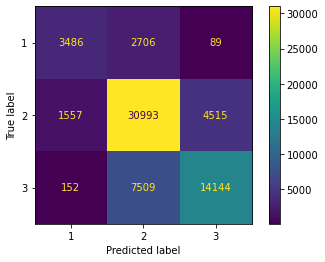

In [70]:
plot_confusion_matrix(lightgbm_gs, X_test, y_test);

In [71]:
cm = confusion_matrix(y_test, lightgbm_gs_preds)
low_damage = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
medium_damage = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
complete_destruction = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
print(f'The model correctly predicts {round(low_damage*100, 2)}% of low damage.')
print(f'The model correctly predicts {round(medium_damage*100, 2)}% of medium damage.')
print(f'The model correctly predicts {round(complete_destruction*100, 2)}% of complete destruction.')

The model correctly predicts 55.5% of low damage.
The model correctly predicts 83.62% of medium damage.
The model correctly predicts 64.87% of complete destruction.


### Export the model

In [69]:
#with open ('../Models/lightgbm_gs.pickle', 'wb') as f:
#    pickle.dump(lightgbm_gs, f, pickle.HIGHEST_PROTOCOL)